In [103]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torch.optim.lr_scheduler import ExponentialLR
from torchviz import make_dot

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import datetime
import time
import random
import os

# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB


In [104]:
class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)

        self.conv_pw1 = self.pointwise_conv(8, 16, stride=1)
        self.conv_pw2 = self.pointwise_conv(16, 32, stride=1)
        self.conv_pw3 = self.pointwise_conv(32, 64, stride=1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)  # Add fully connected layer

    def pointwise_conv(self, inp, oup, stride):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, stride, 0, bias=False),  # Pointwise convolution
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv_pw1(x)
        x = self.conv_pw2(x)
        x = self.conv_pw3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

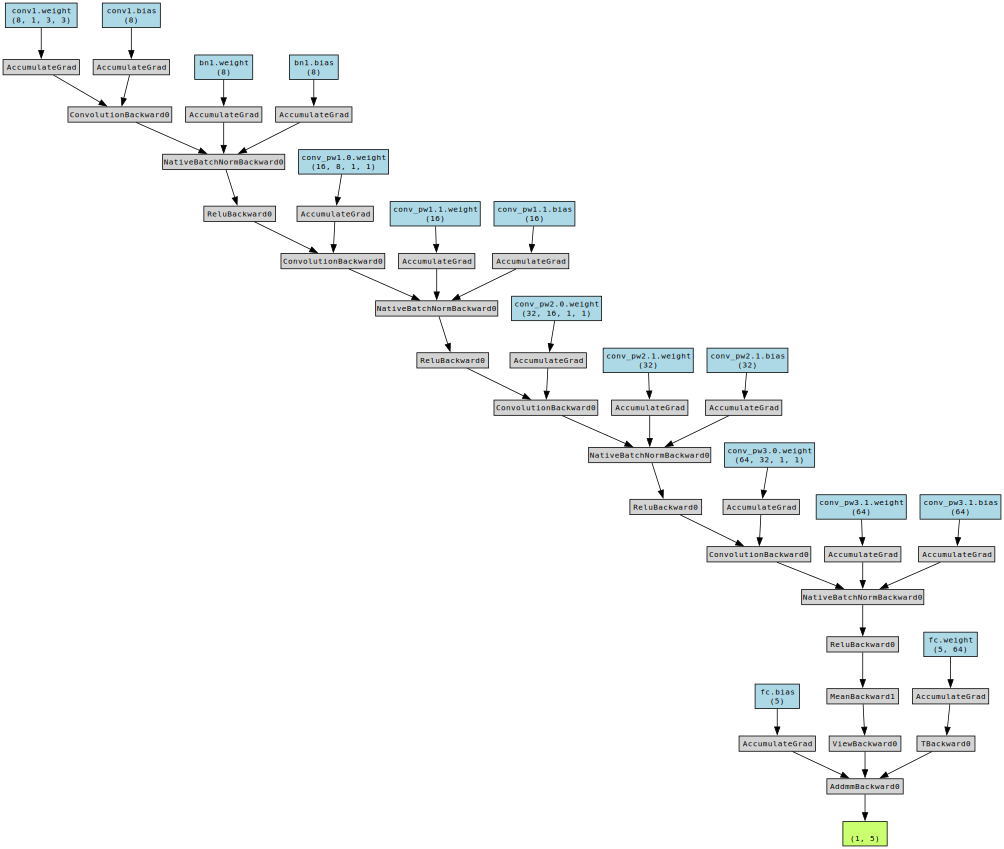

In [105]:
model = MobileNetV1(num_classes=5)

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 10, 10)

# Generate the computational graph
graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Display the graph (in Jupyter, IPython, etc., this line will directly render the graph)
graph.render("PAttLite_Model", format='png', directory='model_visualization')

# To display in a Jupyter notebook without saving to file
graph

In [106]:
in_pth = "C:/Users/Lisa/Rezanur/Pytorch/Safety and Security/Kia Soul Aggresive Driving Data/CSV/Model_Input_1/"

In [107]:
Normal = pd.read_csv(in_pth + "train_normal.csv").astype(str)
Abnormal_Break = pd.read_csv(in_pth + "train_abrupt_breaks.csv").astype(str)
Abnormal_Lane = pd.read_csv(in_pth + "train_lane_changes.csv").astype(str)
Abnormal_Speed = pd.read_csv(in_pth + "train_over_speed.csv").astype(str)
DFRS_Attack = pd.read_csv(in_pth + "DFRS_Attack.csv").astype(str)

Normal_Test = pd.read_csv(in_pth + "test_normal.csv").astype(str)
Un_Break_ID = pd.read_csv(in_pth + "test_abrupt_breaks.csv").astype(str)
Un_Lane_Change = pd.read_csv(in_pth + "test_lane_changes.csv").astype(str)
Un_Over_Speed = pd.read_csv(in_pth + "test_over_speed.csv").astype(str)
Spoofing_Unknown = pd.read_csv(in_pth + "test_spoofing.csv").astype(str)
Sit_Replay_Attack = pd.read_csv(in_pth + "test_replay.csv").astype(str)

C:\Users\Lisa\AppData\Local\Temp\ipykernel_6468\3793067736.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Sit_Replay_Attack = pd.read_csv(in_pth + "test_replay.csv").astype(str)


In [108]:
Normal = Normal[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Abnormal_Break = Abnormal_Break[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Abnormal_Lane = Abnormal_Lane[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Abnormal_Speed = Abnormal_Speed[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
DFRS_Attack = DFRS_Attack[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]

Normal_Test = Normal_Test[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Un_Break_ID = Un_Break_ID[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Un_Lane_Change = Un_Lane_Change[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Un_Over_Speed = Un_Over_Speed[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Spoofing_Unknown = Spoofing_Unknown[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
Sit_Replay_Attack = Sit_Replay_Attack[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]

In [109]:
def slice_and_reshape_dataframe(df, lbl, chunk_size=20, overlap=0.5):
    """
    Slice a DataFrame into overlapping chunks of a specified size, apply label encoding and min-max scaling,
    and reshape each chunk.

    Parameters:
    df (DataFrame): The DataFrame to be sliced.
    lbl (str): The label for the chunks.
    chunk_size (int): The size of each chunk.
    overlap (float): The fraction of overlap between chunks.

    Returns:
    list: A list of reshaped arrays, each containing a chunk of the original DataFrame along with its label.
    """
    # Initialize LabelEncoder and MinMaxScaler
    label_encoder = LabelEncoder()
    min_max_scaler = MinMaxScaler()

    # Apply label encoding and min-max scaling to the DataFrame
    df_encoded_scaled = df.apply(label_encoder.fit_transform)
    df_encoded_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_encoded_scaled), columns=df_encoded_scaled.columns)

    step_size = int(chunk_size * (1 - overlap))
    chunk_list = []

    for start in range(0, len(df_encoded_scaled) - chunk_size + 1, step_size):
        chunk = df_encoded_scaled.iloc[start:start + chunk_size]
        # Reshape the chunk to (1, 20, 10)
        chunk_reshaped = chunk.values.reshape(1, chunk_size, 10)
        chunk_list.append([chunk_reshaped, lbl])

    # Handle the last chunk if there are excess rows
    if len(df_encoded_scaled) % step_size != 0:
        last_chunk_start = len(df_encoded_scaled) - chunk_size
        last_chunk = df_encoded_scaled.iloc[last_chunk_start:]
        if len(last_chunk) == chunk_size:
            last_chunk_reshaped = last_chunk.values.reshape(1, chunk_size, 10)
            chunk_list.append([last_chunk_reshaped, lbl])

    return chunk_list

In [110]:
# Create lists to hold the chunks for each DataFrame
chunks_list_train = []
#chunk_list_Ab_test = []
#chunk_list_At_test = []

chunk_size=20

# Slice and reshape Normal_C_CAN DataFrame
Normal_1_chunks = slice_and_reshape_dataframe(Normal, '0', chunk_size)
chunks_list_train.extend(Normal_1_chunks)


# Slice and reshape Normal_C_CAN DataFrame
Abnormal_Break_chunks = slice_and_reshape_dataframe(Abnormal_Break, '1', chunk_size)
chunks_list_train.extend(Abnormal_Break_chunks)


Abnormal_Lane_chunks = slice_and_reshape_dataframe(Abnormal_Lane, '2', chunk_size)
chunks_list_train.extend(Abnormal_Lane_chunks)


Abnormal_Speed_chunks = slice_and_reshape_dataframe(Abnormal_Speed, '3', chunk_size)
chunks_list_train.extend(Abnormal_Speed_chunks)



# Slice and reshape Normal_C_CAN DataFrame
Normal_Test_chunks = slice_and_reshape_dataframe(Normal_Test, '0', chunk_size)
chunks_list_train.extend(Normal_Test_chunks)


Un_Break_ID_chunks = slice_and_reshape_dataframe(Un_Break_ID, '1', chunk_size)
chunks_list_train.extend(Un_Break_ID_chunks)


Un_Lane_Change_chunks = slice_and_reshape_dataframe(Un_Lane_Change, '2', chunk_size)
chunks_list_train.extend(Un_Lane_Change_chunks)


Un_Over_Speed_chunks = slice_and_reshape_dataframe(Un_Over_Speed, '3', chunk_size)
chunks_list_train.extend(Un_Over_Speed_chunks)




# Slice and reshape Door_C_CAN DataFrame
DFRS_Attack_chunks = slice_and_reshape_dataframe(DFRS_Attack, '4', chunk_size)
chunks_list_train.extend(DFRS_Attack_chunks)




# Slice and reshape Door_C_CAN DataFrame
Spoofing_Unknown_C_CAN_chunks = slice_and_reshape_dataframe(Spoofing_Unknown, '4', chunk_size)
chunks_list_train.extend(Spoofing_Unknown_C_CAN_chunks)



# Slice and reshape Door_C_CAN DataFrame
Situational_Replay_C_CAN_chunks = slice_and_reshape_dataframe(Sit_Replay_Attack, '4', chunk_size)
chunks_list_train.extend(Situational_Replay_C_CAN_chunks)

# Slice and reshape Normal_C_CAN DataFrame
Normal_Test_chunks = slice_and_reshape_dataframe(Normal_Test, '0', chunk_size)
chunks_list_train.extend(Normal_Test_chunks)

In [111]:
Normal_Test_chunks[0][0].shape

(1, 20, 10)

In [112]:
# Split the data into train and test sets
X_train, X_test = train_test_split(chunks_list_train, test_size=0.2, random_state=42)

In [113]:
"""# Function to split chunks list into training and validation
def split_chunks(chunks, validation_size=0.05):
    train_chunks, val_chunks = train_test_split(chunks, test_size=validation_size, random_state=42)
    return train_chunks, val_chunks

# Split each chunks list into training and validation
chunks_train, chunks_val = split_chunks(chunks_list_train, validation_size=0.05)
chunks_test, chunks_val = split_chunks(chunks_train, validation_size=0.05)
Ab_test_train, Ab_test_val = split_chunks(chunk_list_Ab_test, validation_size=0.05)
At_test_train, At_test_val = split_chunks(chunk_list_At_test, validation_size=0.05)

# Combine all validation chunks into one list
all_validation_chunks = []
all_validation_chunks.extend(chunks_val)
all_validation_chunks.extend(Ab_test_val)
all_validation_chunks.extend(At_test_val)"""

'# Function to split chunks list into training and validation\ndef split_chunks(chunks, validation_size=0.05):\n    train_chunks, val_chunks = train_test_split(chunks, test_size=validation_size, random_state=42)\n    return train_chunks, val_chunks\n\n# Split each chunks list into training and validation\nchunks_train, chunks_val = split_chunks(chunks_list_train, validation_size=0.05)\nchunks_test, chunks_val = split_chunks(chunks_train, validation_size=0.05)\nAb_test_train, Ab_test_val = split_chunks(chunk_list_Ab_test, validation_size=0.05)\nAt_test_train, At_test_val = split_chunks(chunk_list_At_test, validation_size=0.05)\n\n# Combine all validation chunks into one list\nall_validation_chunks = []\nall_validation_chunks.extend(chunks_val)\nall_validation_chunks.extend(Ab_test_val)\nall_validation_chunks.extend(At_test_val)'

In [114]:
def prepare_data(chunk_list, label_mapping, batch_size=64, shuffle=False):
    # Extract features and labels from chunk_list
    X = [chunk[0] for chunk in chunk_list]  # Features
    y = [chunk[1] for chunk in chunk_list]  # Labels

    # Convert features to PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Convert string labels to numerical labels
    y_numerical = [label_mapping[label] for label in y]
    y_tensor = torch.tensor(y_numerical, dtype=torch.long)

    # Create dataset and data loader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [115]:
label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}  # Define the mapping from string labels to numerical labels

# Prepare data using the function
train_loader = prepare_data(X_train, label_mapping)
test_loader = prepare_data(X_test, label_mapping)
#val_loader = prepare_data(all_validation_chunks, label_mapping)

Attack_test_loader = prepare_data(chunk_list_At_test, label_mapping)
Ab_test_loader = prepare_data(chunk_list_Ab_test, label_mapping)

In [116]:
# Define the loss function (e.g., cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV1(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv_pw1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_pw2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_pw3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

In [117]:
# Assuming 'device' and other necessary components are defined earlier

# Initialize variables for early stopping
best_val_loss = np.Inf
patience = 10  # Number of epochs to wait for improvement
counter = 0  # Counter for epochs without improvement
num_epochs = 1000

# Move model to device
model.to(device)

train_dataset_len = len(train_loader.dataset)
test_dataset_len = len(test_loader.dataset)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item() * inputs.size(0)  # Accumulate loss
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_loss / train_dataset_len
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() * val_inputs.size(0)
            
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / test_dataset_len
    val_accuracy = correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}")
    
    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0  # Reset counter if validation loss improves
        # Save the model
        torch.save(model.state_dict(), "Poin_Mob_Net_20_Over_50.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

Epoch [1/1000], Train Loss: 0.4849, Val Loss: 0.3899, Val Accuracy: 81.66%
Epoch [2/1000], Train Loss: 0.2589, Val Loss: 0.2798, Val Accuracy: 88.15%
Epoch [3/1000], Train Loss: 0.2106, Val Loss: 0.2327, Val Accuracy: 91.13%
Epoch [4/1000], Train Loss: 0.1834, Val Loss: 0.1552, Val Accuracy: 93.88%
Epoch [5/1000], Train Loss: 0.1637, Val Loss: 0.1399, Val Accuracy: 94.30%
Epoch [6/1000], Train Loss: 0.1479, Val Loss: 0.1268, Val Accuracy: 94.98%
Epoch [7/1000], Train Loss: 0.1351, Val Loss: 0.1098, Val Accuracy: 95.69%
Epoch [8/1000], Train Loss: 0.1250, Val Loss: 0.1363, Val Accuracy: 94.52%
Epoch [9/1000], Train Loss: 0.1176, Val Loss: 0.0931, Val Accuracy: 96.45%
Epoch [10/1000], Train Loss: 0.1123, Val Loss: 0.0930, Val Accuracy: 96.45%
Epoch [11/1000], Train Loss: 0.1077, Val Loss: 0.1076, Val Accuracy: 95.86%
Epoch [12/1000], Train Loss: 0.1030, Val Loss: 0.0872, Val Accuracy: 96.74%
Epoch [13/1000], Train Loss: 0.0991, Val Loss: 0.0786, Val Accuracy: 97.04%
Epoch [14/1000], Trai

Epoch [109/1000], Train Loss: 0.0359, Val Loss: 0.0272, Val Accuracy: 99.00%
Epoch [110/1000], Train Loss: 0.0358, Val Loss: 0.0280, Val Accuracy: 98.96%
Epoch [111/1000], Train Loss: 0.0354, Val Loss: 0.0274, Val Accuracy: 98.97%
Epoch [112/1000], Train Loss: 0.0353, Val Loss: 0.0282, Val Accuracy: 98.91%
Epoch [113/1000], Train Loss: 0.0352, Val Loss: 0.0262, Val Accuracy: 99.08%
Epoch [114/1000], Train Loss: 0.0350, Val Loss: 0.0260, Val Accuracy: 99.08%
Epoch [115/1000], Train Loss: 0.0348, Val Loss: 0.0264, Val Accuracy: 99.06%
Epoch [116/1000], Train Loss: 0.0346, Val Loss: 0.0264, Val Accuracy: 99.04%
Epoch [117/1000], Train Loss: 0.0343, Val Loss: 0.0258, Val Accuracy: 99.07%
Epoch [118/1000], Train Loss: 0.0342, Val Loss: 0.0261, Val Accuracy: 99.06%
Epoch [119/1000], Train Loss: 0.0341, Val Loss: 0.0270, Val Accuracy: 99.02%
Epoch [120/1000], Train Loss: 0.0339, Val Loss: 0.0274, Val Accuracy: 98.99%
Epoch [121/1000], Train Loss: 0.0337, Val Loss: 0.0257, Val Accuracy: 99.09%

In [118]:
# Load the saved state dictionary
state_dict = torch.load('Poin_Mob_Net_20_Over_50.pth')

# Rename the keys in the state dictionary
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace('conv_dw', 'conv_pw')
    new_state_dict[new_key] = value

# Load the renamed state dictionary into the model
model = MobileNetV1(num_classes=5)
model.load_state_dict(new_state_dict)
model.eval()

MobileNetV1(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv_pw1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_pw2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_pw3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

In [119]:
def get_prediction(model, dataloader):
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        prediction = np.zeros(len(dataloader.dataset))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if device:
                images = images.type(torch.cuda.FloatTensor)
            prediction[k:k+len(images)] = np.argmax(model(images).data.cpu().numpy(), axis=1)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return prediction, labels

In [120]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Class labels
class_labels = ["Normal", "Abrupt Break", "Abrupt Lane Change", "Abrupt Accelaration", "Attack"]

def plot_confusion_matrix(cf_matrix, class_labels):
    """
    Plot a confusion matrix heatmap with annotations for both numbers and percentages.
    
    Parameters:
        cf_matrix (list of lists): Confusion matrix.
        class_labels (list of str): Class labels.
    """
    # Calculate percentages for each cell
    percentages = np.zeros_like(cf_matrix, dtype=float)
    for i in range(len(cf_matrix)):
        row_sum = sum(cf_matrix[i])
        for j in range(len(cf_matrix)):
            percentages[i][j] = cf_matrix[i][j] / row_sum * 100 if row_sum != 0 else 0

    # Normalize the confusion matrix for the heatmap
    normalized_cf_matrix = np.zeros_like(cf_matrix, dtype=float)
    total = np.sum(cf_matrix)
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix)):
            normalized_cf_matrix[i][j] = cf_matrix[i][j] / total * 100

    # Define custom colormap based on normalized percentages
    cmap_colors = [(0.7, 0.7, 0.7)]  # Start with gray for 0%
    cmap_colors.extend(sns.color_palette("hls", 100))  # Green to red colormap
    custom_cmap = mcolors.ListedColormap(cmap_colors)

    # Plot the confusion matrix as a heatmap with annotations for both numbers and percentages
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cf_matrix, annot=False, cmap=custom_cmap, cbar=False, fmt='w', linewidths=0.5, linecolor='white')

    # Plot the confusion matrix with percentages
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix)):
            # Add actual numbers as text in the center of each cell
            plt.text(j + 0.5, i + 0.4, str(cf_matrix[i][j]), ha='center', va='center', fontsize=15, fontweight='bold', color='black')
            # Add percentages as text below the actual numbers
            plt.text(j + 0.5, i + 0.6, f'{percentages[i][j]:.2f}%', ha='center', va='center', fontsize=15, fontweight='bold', color='black')

    # Add axis labels and title
    plt.xlabel("True Labels", fontweight="bold", fontsize=19, color='darkblue')
    plt.ylabel("Predicted Labels", fontweight="bold", fontsize=19, color='darkblue')

    # Change tick label colors
    ax.set_xticklabels(class_labels, rotation=45, ha='right', color='black', fontweight="bold", fontsize=15)
    ax.set_yticklabels(class_labels, rotation=0, color='black', fontweight="bold", fontsize=15)

    # Change color for "Normal" ticks to green
    ax.get_xticklabels()[class_labels.index("Normal")].set_color('green')
    ax.get_yticklabels()[class_labels.index("Normal")].set_color('green')

    # Change color for "Attack" ticks to red
    for label in ["Normal", "Abrupt Break", "Abrupt Lane Change", "Abrupt Accelaration", "Attack"]:
        if label != "Attack":
            ax.get_xticklabels()[class_labels.index(label)].set_color('darkred')
            ax.get_yticklabels()[class_labels.index(label)].set_color('darkred')
        else:
            ax.get_xticklabels()[class_labels.index(label)].set_color('red')
            ax.get_yticklabels()[class_labels.index(label)].set_color('red')

    plt.tight_layout()
    plt.show()

In [121]:
pred = get_prediction(model, test_loader)
y_pred = pred[0]
y_test = pred[1]

In [122]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[27001     1    11     3     1]
 [    4  5547     0   185     0]
 [  118     2  7281     0     1]
 [    5   276     0  5593     4]
 [    0     0     0     0 22545]]


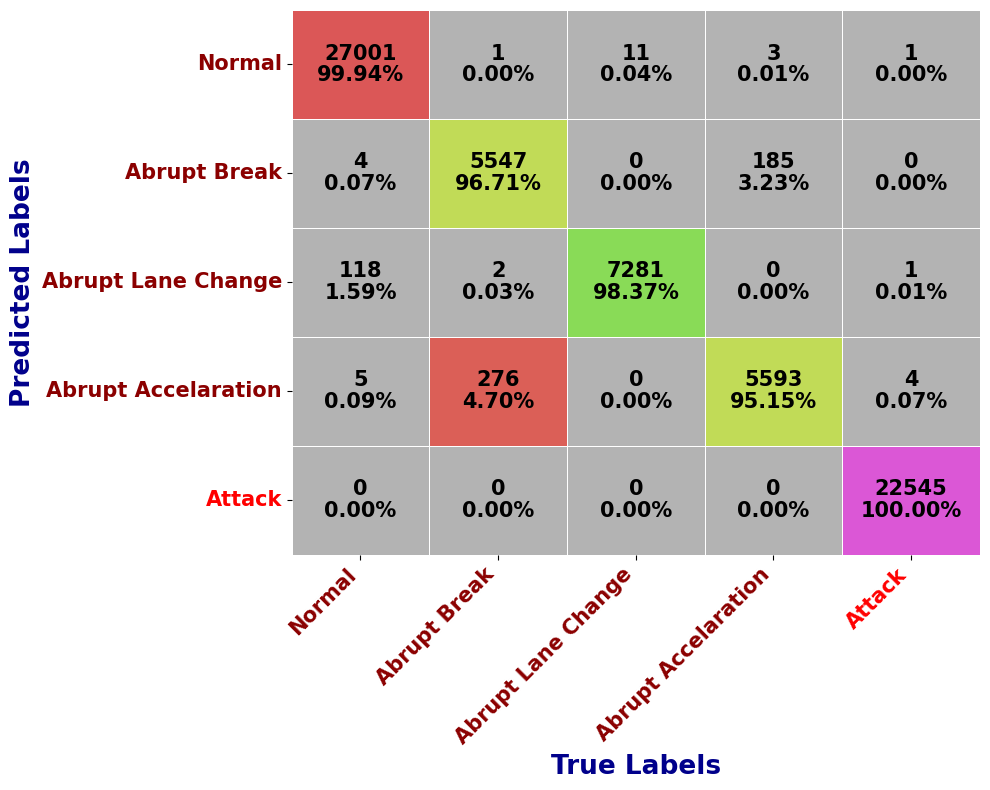

In [123]:
plot_confusion_matrix(cf_matrix, class_labels)

In [124]:
# Define class labels
class_labels = ["Normal", "Aggressive Break", "Aggressive Lane Change", "Aggressive Speed", "Attack"]

# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_labels)

# Print the classification report
print(report)

                        precision    recall  f1-score   support

                Normal       1.00      1.00      1.00     27017
      Aggressive Break       0.95      0.97      0.96      5736
Aggressive Lane Change       1.00      0.98      0.99      7402
      Aggressive Speed       0.97      0.95      0.96      5878
                Attack       1.00      1.00      1.00     22545

              accuracy                           0.99     68578
             macro avg       0.98      0.98      0.98     68578
          weighted avg       0.99      0.99      0.99     68578



# Computer Power Calculation

In [125]:
def process_dataframe(df, chunk_size, overlap):
    """
    Applies label encoding and min-max scaling to a DataFrame and generates chunks.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    chunk_size (int): The size of each chunk.
    overlap (float): The overlap between chunks as a fraction (0 to 1).

    Returns:
    list: A list of DataFrame chunks after processing.
    """
    # Select relevant columns
    df = df[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]

    # Initialize LabelEncoder and MinMaxScaler
    label_encoder = LabelEncoder()
    min_max_scaler = MinMaxScaler()

    # Apply label encoding and min-max scaling to the DataFrame
    df_encoded_scaled = df.apply(label_encoder.fit_transform)
    df_encoded_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_encoded_scaled), columns=df_encoded_scaled.columns)

    # Determine step size based on chunk size and overlap
    step_size = int(chunk_size * (1 - overlap))
    
    # Initialize the list to store the chunks
    chunk_list = []

    # Generate chunks from the encoded and scaled DataFrame
    for start in range(0, len(df_encoded_scaled) - chunk_size + 1, step_size):
        chunk = df_encoded_scaled.iloc[start:start + chunk_size]
        chunk_list.append(chunk)

    return chunk_list

In [55]:
import torch
import torch.nn as nn

# Define the MobileNetV1 model
class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)

        self.conv_pw1 = self.pointwise_conv(8, 16, stride=1)
        self.conv_pw2 = self.pointwise_conv(16, 32, stride=1)
        self.conv_pw3 = self.pointwise_conv(32, 64, stride=1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)  # Add fully connected layer

    def pointwise_conv(self, inp, oup, stride):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, stride, 0, bias=False),  # Pointwise convolution
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv_pw1(x)
        x = self.conv_pw2(x)
        x = self.conv_pw3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Function to calculate FLOPs
def calculate_flops(model, input_size):
    from thop import profile
    
    model = model()
    input = torch.randn(1, *input_size)  # Batch size of 1
    flops, params = profile(model, inputs=(input, ))
    
    return flops, params

# Instantiate the model
model = MobileNetV1

# Input size as per your specification (1, 20, 10)
input_size = (1, 20, 10)

# Calculate FLOPs and parameters
flops, params = calculate_flops(model, input_size)

# Convert FLOPs to MFLOPs
flops_in_mflops = flops / 1e6

print(f"Total FLOPs: {flops} ({flops_in_mflops} MFLOPs)")
print(f"Total Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Total FLOPs: 661184.0 (0.661184 MFLOPs)
Total Parameters: 3333.0


In [101]:
import torch
import torch.nn as nn

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)

        self.conv_pw1 = self.pointwise_conv(8, 16, stride=1)
        self.conv_pw2 = self.pointwise_conv(16, 32, stride=1)
        self.conv_pw3 = self.pointwise_conv(32, 64, stride=1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)  # Add fully connected layer

    def pointwise_conv(self, inp, oup, stride):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, stride, 0, bias=False),  # Pointwise convolution
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv_pw1(x)
        x = self.conv_pw2(x)
        x = self.conv_pw3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Function to calculate Big O notation (time complexity)
def calculate_big_o(model, input_size):
    total_ops = 0

    def conv2d_ops(H, W, C_in, C_out, K):
        return H * W * C_in * C_out * K * K

    def pointwise_conv_ops(H, W, C_in, C_out):
        return H * W * C_in * C_out

    H, W = input_size[1], input_size[2]  # Height and Width of the input
    C_in = 1  # Initial number of input channels
    
    # conv1 layer
    K = 3  # Kernel size for conv1
    C_out = 8  # Number of output channels
    total_ops += conv2d_ops(H, W, C_in, C_out, K)
    
    # Pointwise conv1 layer
    C_in = C_out
    C_out = 16
    total_ops += pointwise_conv_ops(H, W, C_in, C_out)
    
    # Pointwise conv2 layer
    C_in = C_out
    C_out = 32
    total_ops += pointwise_conv_ops(H, W, C_in, C_out)
    
    # Pointwise conv3 layer
    C_in = C_out
    C_out = 64
    total_ops += pointwise_conv_ops(H, W, C_in, C_out)
    
    # Fully connected layer
    total_ops += C_out * 5  # 64 input features to num_classes (5)

    return total_ops

# Instantiate the model
model = MobileNetV1(num_classes=5)

# Input size (batch_size, channels, height, width)
input_size = (1, 1, 20, 10)

# Calculate Big O notation
total_operations = calculate_big_o(model, input_size)

print(f"Total Operations (Approximate Big O): {total_operations}")

Total Operations (Approximate Big O): 55520


In [102]:
import torch.profiler

# Define the MobileNetV1 model
class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)

        self.conv_pw1 = self.pointwise_conv(8, 16, stride=1)
        self.conv_pw2 = self.pointwise_conv(16, 32, stride=1)
        self.conv_pw3 = self.pointwise_conv(32, 64, stride=1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)  # Add fully connected layer

    def pointwise_conv(self, inp, oup, stride):
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, stride, 0, bias=False),  # Pointwise convolution
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv_pw1(x)
        x = self.conv_pw2(x)
        x = self.conv_pw3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize the model
model = MobileNetV1(num_classes=5)

# Create a random input tensor with the specified input size (batch_size, channels, height, width)
input_tensor = torch.randn(1, 1, 20, 10)

# Use torch.profiler to profile the model
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
    with_flops=True,
) as prof:
    model(input_tensor)

# Print the profiling results
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
print(prof.key_averages().table(sort_by="flops", row_limit=10))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls   Total FLOPs  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    aten::conv2d        34.44%       1.860ms        36.83%       1.989ms     497.250us      93.75 Kb       6.25 Kb             4   1104000.000  
               aten::convolution         1.07%      58.000us        36.33%       1.962ms     490.500us      93.75 Kb           0 b             4            --  
              aten::_convolution         0.54%      29.000us        35.25%       1.904ms     476.000us      93.75 Kb           0 b             4            --  
               aten::thnn_conv2d  

In [136]:
import torch
import torch.nn as nn
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from thop import profile
from torch.profiler import profile as torch_profile, record_function, ProfilerActivity

def process_dataframe(df, chunk_size, overlap):
    """
    Applies label encoding and min-max scaling to a DataFrame and generates chunks.
    Also calculates the computational complexity of the preprocessing steps.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    chunk_size (tuple): The size of each chunk (e.g., (1, 1, 20, 10)).
    overlap (float): The overlap between chunks as a fraction (0 to 1).

    Returns:
    tuple: A list of DataFrame chunks after processing and the complexity of preprocessing steps.
    """
    start_time = time.time()

    # Select relevant columns (O(m))
    df = df[['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Time_Gap']]
    n = len(df)
    m = len(df.columns)

    # Initialize LabelEncoder and MinMaxScaler (O(1))
    label_encoder = LabelEncoder()
    min_max_scaler = MinMaxScaler()

    # Apply label encoding and min-max scaling to the DataFrame (O(n * m))
    df_encoded_scaled = df.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' else col)
    df_encoded_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_encoded_scaled), columns=df_encoded_scaled.columns)

    # Convert the DataFrame into chunks of the specified size
    chunk_list = []
    step_size = int(chunk_size[2] * (1 - overlap))  # Step size based on overlap

    # Generate chunks from the encoded and scaled DataFrame (O(n * chunk_size * m / step_size))
    for start in range(0, len(df_encoded_scaled) - chunk_size[2] + 1, step_size):
        chunk = df_encoded_scaled.iloc[start:start + chunk_size[2], :chunk_size[3]]
        chunk = chunk.values.reshape(chunk_size)  # Reshape to (1, 1, 20, 10)
        chunk_list.append(chunk)

    # Total complexity for preprocessing: O(n * m + n * chunk_size * m / step_size)
    preprocessing_complexity = n * m + (n * chunk_size[2] * m) / step_size

    end_time = time.time()
    preprocessing_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds

    return chunk_list, preprocessing_complexity, preprocessing_time_ms

# Define the MobileNetV1 model
class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        # Convolutional Layer 1 (O(K^2 * C_in * C_out * H * W))
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)  # Batch normalization (O(H * W * C_out))
        self.relu = nn.ReLU(inplace=True)  # ReLU activation (O(H * W * C_out))

        # Pointwise Convolution Layers (O(C_in * C_out * H * W) for each)
        self.conv_pw1 = self.pointwise_conv(8, 16, stride=1)
        self.conv_pw2 = self.pointwise_conv(16, 32, stride=1)
        self.conv_pw3 = self.pointwise_conv(32, 64, stride=1)

        # Adaptive Average Pooling (O(H * W * C_out))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer (O(n * p), where n = input size, p = output size)
        self.fc = nn.Linear(64, num_classes)  # Add fully connected layer

    def pointwise_conv(self, inp, oup, stride):
        # Pointwise convolution (O(C_in * C_out * H * W))
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, stride, 0, bias=False),  # Pointwise convolution
            nn.BatchNorm2d(oup),  # Batch normalization (O(H * W * C_out))
            nn.ReLU(inplace=True)  # ReLU activation (O(H * W * C_out))
        )
    
    def forward(self, x):
        # Big O: O(K^2 * C_in * C_out * H * W) for convolution
        x = self.conv1(x)
        x = self.bn1(x)  # O(H * W * C_out)
        x = self.relu(x)  # O(H * W * C_out)

        # Pointwise Convolutions (O(C_in * C_out * H * W))
        x = self.conv_pw1(x)
        x = self.conv_pw2(x)
        x = self.conv_pw3(x)

        # Pooling (O(H * W * C_out))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully Connected Layer (O(n * p))
        x = self.fc(x)
        return x

# Your provided corrected data
data = {
    'CAN_ID': ['0220', '0316', '043F', '0440', '0220', '0018', '0316', '043F', '0440', '0220', 
               '0316', '043F', '0440', '0220', '0316', '043F', '0440', '0220', '0316', '043F'],
    'One': ['EF', '45', '0A', 'FF', 'F5', '00', '45', '0A', 'FF', 'F6', 
            '45', '0A', 'FF', 'F4', '45', '0A', 'FF', 'F4', '45', '0A'],
    'Two': ['23', '9F', '45', '41', '2B', '00', '9F', '45', '91', '33', 
            '9F', '45', 'E1', '3B', '9E', '45', '31', '03', '9C', '45'],
    'Three': ['AB', '64', '60', '16', 'A9', '00', '84', '60', '17', 'AB', 
              'A2', '60', '17', 'A9', 'C0', '60', '17', 'A2', 'EA', '60'],
    'Four': ['3C', '36', 'FF', '00', '1C', '60', '36', 'FF', '00', '0C', 
             '36', 'FF', '00', '2C', '36', 'FF', '00', '14', '36', 'FF'],
    'Five': ['0C', '9F', '8F', 'FF', '0C', '00', '9F', '8F', 'FF', '0C', 
             '9F', '8F', 'FF', '0C', '9D', '8F', 'FF', '0C', '9B', '8F'],
    'Six': ['30', '2C', 'B8', 'E0', '30', '00', '2C', 'DC', '04', '30', 
            '2C', 'FC', '20', '20', '2C', '1C', '3C', '30', '2C', '48'],
    'Seven': ['A3', '13', '33', '33', 'AC', '20', '13', '33', '34', 'B1', 
              '13', '33', '34', 'B4', '13', '34', '34', 'B7', '13', '34'],
    'Eight': ['10', '7F', '00', '77', '10', '00', '7F', '00', '07', '10', 
              '7F', '00', '1E', '10', '7F', '00', '35', '10', '7F', '00'],
    'Time_Gap': [0.3, 1.3, 0.2, 0.3, 0.3, 1.2, 0.3, 0.2, 0.2, 0.3, 
                 0.3, 0.2, 0.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
}

df = pd.DataFrame(data)

# Process the dataframe
chunks, preprocessing_complexity, preprocessing_time_ms = process_dataframe(df, chunk_size=(1, 1, 20, 10), overlap=0.2)

# Print the results for preprocessing
print(f"Number of chunks generated: {len(chunks)}")
print(f"Preprocessing complexity: O({preprocessing_complexity})")
print(f"Preprocessing time: {preprocessing_time_ms:.2f} ms")

# Create an instance of the MobileNetV1 model
model = MobileNetV1(num_classes=5)

# Define a dummy input tensor with the specific input size based on the chunk size (1, 1, 20, 10)
input_tensor = torch.randn(1, 1, 20, 10)  # Batch size 1, 1 channel, 20x10 input size

# Measure inference time using torch.profiler
with torch_profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(input_tensor)

# Print profiler results
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

# Optional: Save the profiler results to a file
prof.export_chrome_trace("mobilenet_v1_profiler.json")

# Calculate the number of FLOPs and parameters for the MobileNetV1 model
flops, params = profile(model, inputs=(input_tensor,))

# Convert FLOPs to MFLOPs (Millions of FLOPs)
mflops = flops / 1e6

# Print the results for the model
print(f"MFLOPs for MobileNetV1 model: {mflops}")
print(f"Number of parameters in the model: {params}")

Number of chunks generated: 1
Preprocessing complexity: O(450.0)
Preprocessing time: 3.52 ms
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        37.94%     376.000us       100.00%     991.000us     991.000us             1  
                    aten::conv2d         1.31%      13.000us        27.35%     271.000us      67.750us             4  
               aten::convolution         4.64%      46.000us        26.03%     258.000us      64.500us             4  
              aten::_convolution         2.62%      26.000us        21.39%     212.000us      53.000us             4  
               aten::thnn_conv2d         1.01%      10.000us        18.77%

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
from thop import profile
from torch.profiler import profile as torch_profile, record_function, ProfilerActivity

# Part 1: Preprocessing Data
def recurrence_plot(signal):
    """Convert a time series signal to a recurrence plot."""
    n = len(signal)
    rp = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            rp[i, j] = np.abs(signal[i] - signal[j])
    return rp

def generate_images(signals):
    """Generate recurrence plot images for each signal."""
    images = []
    for signal in signals:
        rp = recurrence_plot(signal)
        images.append(rp)
    return np.array(images)

# Example signals
acc_x = np.random.rand(50)
acc_y = np.random.rand(50)
acc_z = np.random.rand(50)
grav_x = np.random.rand(50)
grav_y = np.random.rand(50)
grav_z = np.random.rand(50)
rpm = np.random.rand(50)
speed = np.random.rand(50)
throttle = np.random.rand(50)

# Start the preprocessing timer
start_time = time.time()

# Generate images
images_acc = generate_images([acc_x, acc_y, acc_z])
images_grav = generate_images([grav_x, grav_y, grav_z])
images_rpm = generate_images([rpm, speed, throttle])

# Stack images into a multi-channel tensor (should have 9 channels total)
input_data = np.concatenate((images_acc, images_grav, images_rpm), axis=0)
input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Stop the preprocessing timer
end_time = time.time()
preprocessing_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds

# Calculate preprocessing complexity
n = input_data.size(0)  # Number of samples
m = input_data.size(1) * input_data.size(2)  # Number of features
preprocessing_complexity = n * m

print(f"Number of chunks generated: 1")  # Since this is just a single batch
print(f"Preprocessing complexity: O({preprocessing_complexity})")
print(f"Preprocessing time: {preprocessing_time_ms:.2f} ms")

class DriverBehaviorCNN(nn.Module):
    def __init__(self):
        super(DriverBehaviorCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=9, out_channels=32, kernel_size=7, padding=3)  # 7x7 filter size with padding
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=3)  # 7x7 filter size with padding
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Adjust the size based on the correct calculations
        self.fc1 = nn.Linear(64 * 12 * 12, 256)  # Adjusted for 12x12 size
        self.fc2 = nn.Linear(256, 5)  # Assuming 5 classes for the behavior

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)  # Flattening for fully connected layer with correct size
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = DriverBehaviorCNN()

# Part 3: Measure Model Inference Time using Profiler
with torch_profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        output = model(input_data)

# Print profiler results
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

# Part 4: Calculate FLOPs and Number of Parameters
flops, params = profile(model, inputs=(input_data,))
mflops = flops / 1e6  # Convert to MFLOPs

print(f"MFLOPs for DriverBehaviorCNN model: {mflops:.6f}")
print(f"Number of parameters in the model: {params:.1f}")

Number of chunks generated: 1
Preprocessing complexity: O(450)
Preprocessing time: 21.82 ms
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        12.83%     304.000us       100.00%       2.369ms       2.369ms             1  
                     aten::conv2d         0.38%       9.000us        46.35%       1.098ms     549.000us             2  
                aten::convolution         1.48%      35.000us        45.97%       1.089ms     544.500us             2  
               aten::_convolution         0.76%      18.000us        44.49%       1.054ms     527.000us             2  
         aten::mkldnn_convolution        43.10%       1.021ms       